##  Прогнозирование с помощью 
##  экспоненциального сглаживания и SARIMA

##  Выбор лучшей модели



In [2]:
#  Дополнительное чтение

#  Описание процудуры, выполняющей экспоненциальное сглаживание
#  https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html

#  Самый популярный учебник по прогнозированию
#  https://otexts.org/fpp2/

In [3]:
#  Активируем библиотеки, необходимые для работы

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

import os

from statsmodels.tsa.api import ExponentialSmoothing



###  Временной ряд: авиаперевозки (series G)
###  Предварительный анализ данных

In [4]:
#  Внимание!  Ячейку надо редактировать!


#  1  Задаем путь к рабочей папке
#  Найдите путь к папке, где лежит файл с данными
#  Внимание!  Придется переделать слеши, они не такие, как в Windows

#  2  Задаем имя файла, в котором столбец с данными
#  Найдите имя файла с данными в папке, где лежит файл с данными

#  1  
path = "C:/aaa/R/_R_лекции/R_занятие_07_forecast/data/03_series_g/"

#  2  
file_name = 'series_g.csv'

In [5]:

os.chdir(path)

zzz = pd.read_csv(file_name, sep = ";")

In [6]:
#  Самопроверка. Все хорошо? Смотрим начало таблицы с данными. 
zzz.head()

,date,series_g
0,JAN 1949,112
1,FEB 1949,118
2,MAR 1949,132
3,APR 1949,129
4,MAY 1949,121


In [7]:
#  Самопроверка. Все хорошо? Смотрим конец таблицы с данными.
zzz.tail()

,date,series_g
139,AUG 1960,606
140,SEP 1960,508
141,OCT 1960,461
142,NOV 1960,390
143,DEC 1960,432


####  Определяем номер столбца с данными. <br>

Смотрим на предыдущие таблицы. <br>

Первый столбец не считаем, у него нет заголовка. (Это индекс, там имена/номера строк) <br>
Второй столбец содержит даты, он нам не нужен.  <br>
Но его номер 0, потому что в Питоне пересчет начинается с 0! <br>

Третий столбец содержит временной ряд, он нам и нужен. <br>
Но его номер 1, потому что при пересчете сразу после 0 идет 1  <br>

Итак, данные в третьем столбце таблицы, но это столец номер 1  <br>

In [8]:
#  Внимание!  Ячейку надо редактировать!


#  Указываем номер столбца с данными

column_num = 1

In [9]:
zzz_1 = zzz[ zzz.columns[column_num] ]

#  zzz_1

In [10]:
#  Внимание!  Ячейку надо редактировать!

#  На сколько месяцев желаем прогнозировать?
horizon_ = 12





###  Разделяем ряд на обучающее и тестовое множество
####  Для экспоненциального сглаживания

In [11]:
#  Сколько месяцев в исторических данных?
len(zzz_1)

144

In [12]:
#  Сколько месяцев в обучающей части данных?

train_length = len(zzz_1) - horizon_

train_length

132

In [13]:
#  Обучающая часть ряда
#  На этой части временного ряда обучаем модель

zzz_train = zzz_1.iloc[0:train_length]

In [14]:
zzz_train

0      112
1      118
2      132
3      129
4      121
      ... 
127    559
128    463
129    407
130    362
131    405
Name: series_g, Length: 132, dtype: int64

In [15]:
#  Тестовая часть ряда
#  На этой части временного ряда проверяем качество модели

zzz_test = zzz_1.iloc[train_length:len(zzz_1)]

In [16]:
zzz_test

132    417
133    391
134    419
135    461
136    472
137    535
138    622
139    606
140    508
141    461
142    390
143    432
Name: series_g, dtype: int64

###  Визуализация.
Ищем особенности прогнозируемого ряда

Построим график временного ряда <br>
Проверим,  <br>
какой тип тренда (например линейный или нет) и  <br>
какой тип сезонности ( аддитивный или мультипликативный). 


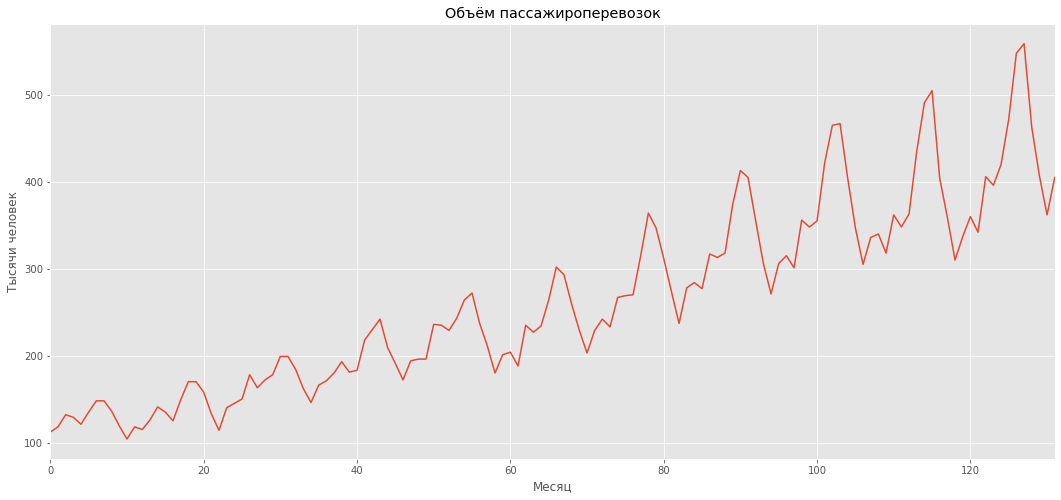

In [17]:
#  Внимание!  Ячейку можно редактировать!
#  А можно не редактировать...
#  Можно изменить размер картинки, подписи осей и заголовок

#  Указываем размер картинки
plt.figure(figsize=(18, 8))

zzz_train.plot()

plt.xlabel(u'Месяц')
plt.ylabel(u'Тысячи человек')
plt.title(u'Объём пассажироперевозок')


plt.show()

Следующую ячейку обсуждаем, если останется время <br>
В ней на график добавляются даты

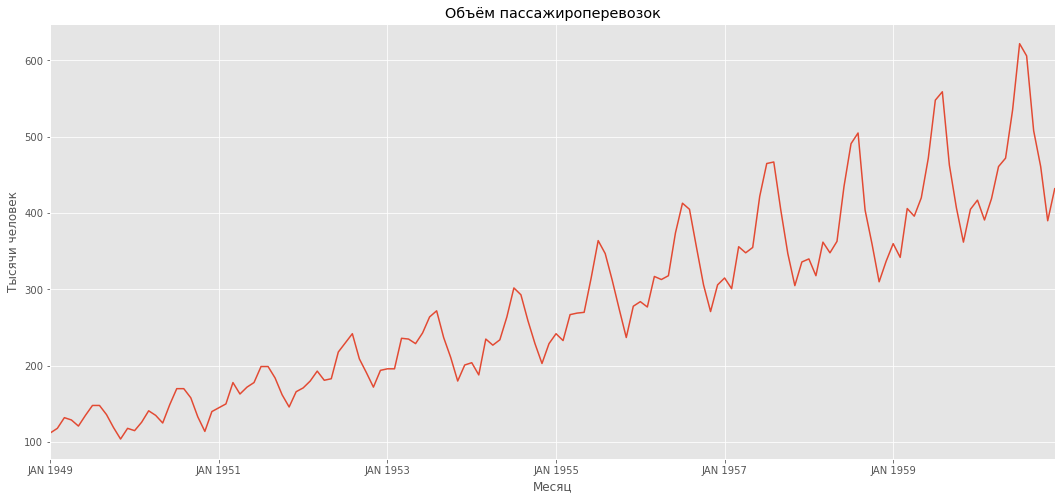

In [18]:
#  Внимание!  Ячейку можно редактировать!
#  Если на предыдущем графике все устраивает, выполнять не надо


#  В каком столбце брать даты?
zzz_2 = zzz[ zzz.columns[0] ]

#  В каких позициях на оси размещать даты? 
y_pos = np.arange(0, 144, 24)



plt.figure(figsize=(18, 8))

zzz_1.plot()

plt.xlabel(u'Месяц')
plt.ylabel(u'Тысячи человек')
plt.title(u'Объём пассажироперевозок')

# Добавляем даты на график
plt.xticks(y_pos, zzz_2[y_pos])

plt.show()

#### Задаем себе 5 вопросов <br>

1.  Есть ли у временного ряда тренд?<br>
1.1  Если есть, то какой (линия, парабола, кубическая парабола)?<br>

2.  Есть ли у временного ряда сезонность? <br> 
2.1  Если есть, то какая (аддитивная, мультипликативная)?<br>

3.  Меняет ли ряд свой характер?

4.  Есть ли у ряда выбросы?

5.  Есть ли у ряда пропуски?

#### Ответим себе на 5 вопросов <br>

1.  У временного ряда линейный тренд. <br>

2.  У временного ряда мультипликативная сезонность. <br>

3.  Ряд не меняет свой характер. <br>

4.  У ряда нет выбросов. <br>

5.  У ряда нет пропусков. <br>


####  Замечание для знатоков

Применяя экспоненциальное сглаживание логарифмировать не надо!  <br>
Процедура справится с любым вариантом, надо только правильно задать значения параметров. 


###  Приступаем к прогнозированию


In [19]:
#  Внимание!  Ячейку надо редактировать!

#  Сообщаем модели ключевые параметры


#  На сколько месяцев желаем прогнозировать?
#  Уже было определено, но здесь повторяем для наглядности
horizon_ = 12


#  Какой тип сезонности?

season_type = 'multiplicative'
#  season_type = 'additive'


#  Какой период сезонных отклонений?

seas_period_ = 12
#  freq_ = 4
#  freq_ = 7
#  freq_ = 24


###  Прогноз с помощью экспоненциального сглаживания

###  Exponential Smoothing      Holt-Winters

In [20]:

#  Всегда trend='additive' по рекомендации Hyndman'а
#  Всегда damped = True

#  y_hat_avg = test.copy()
fit1 = ExponentialSmoothing(zzz_train ,seasonal_periods=seas_period_ ,
                            trend='additive', seasonal=season_type, damped = True).fit()



C:\Users\USER\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [21]:
#   len(zzz_train)

In [22]:
fitted_ = fit1.predict(0, len(zzz_train) + horizon_ - 1)

In [23]:
fitted_

0      117.697170
1      121.345490
2      132.153831
3      126.739691
4      118.424466
          ...    
139    638.522300
140    524.253163
141    458.972684
142    403.736056
143    431.783773
Length: 144, dtype: float64

In [24]:
#   len(fitted_)

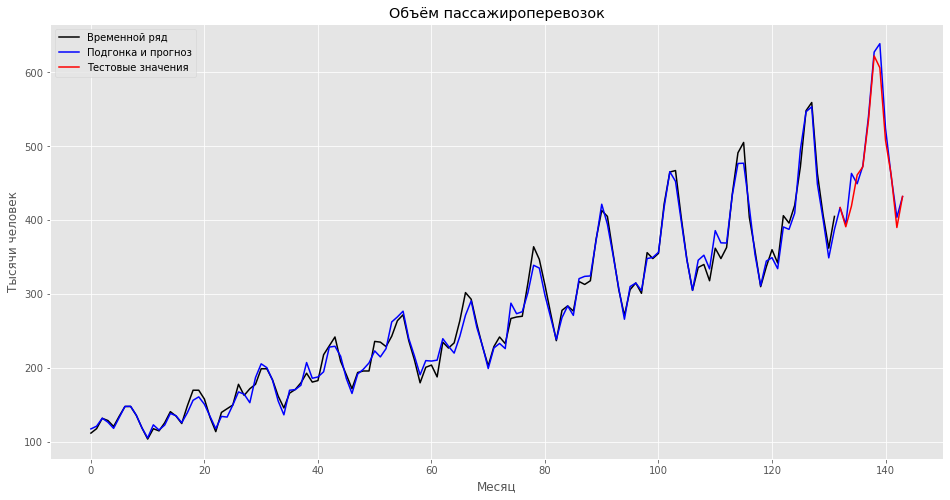

In [25]:
#  Внимание!  Ячейку можно редактировать!

plt.figure(figsize=(16,8))
plt.plot(zzz_train, label='Временной ряд', c = 'black')
plt.plot(fitted_, label='Подгонка и прогноз', c = 'blue')
plt.plot(zzz_test, label='Тестовые значения', c = 'red')

plt.legend(loc='best')

plt.xlabel(u'Месяц')
plt.ylabel(u'Тысячи человек')
plt.title(u'Объём пассажироперевозок')

plt.show()

Это прогноз модели экспоненциальное сглаживание для тестового множества<br>
Спрогнозированные значения  для тестового множества <br>
Получены для оценки качества прогноза для модели экспоненциальное сглаживание

Это не окончательный прогноз

Для получения прогноза по всем историческим данным  <br>
надо вернуться к первому скрипту

In [26]:
forecast_ = fitted_.iloc[len(zzz_train) : len(fitted_)]
forecast_

132    416.880499
133    394.081804
134    463.146184
135    449.154364
136    473.079572
137    540.229247
138    627.202264
139    638.522300
140    524.253163
141    458.972684
142    403.736056
143    431.783773
dtype: float64

In [27]:
#   Оценим качество модели

#   Mean Absolute Percentage Error
#   Используется неидеальная формула.
#  Если значения временного ряда могут равняться нулю, формулу надо будет менять

MAPE_exp_smooth = np.mean(np.abs((forecast_.to_numpy() - zzz_test.to_numpy())/zzz_test.to_numpy()))*100

print("MAPE для экспоненциального сглаживания = ", MAPE_exp_smooth)

MAPE для экспоненциального сглаживания =  2.3785872425864603


###  Объяснение вычислений MAPE
####  Необязательная часть скрипта

In [28]:
forecast_.to_numpy()

array([416.88049902, 394.08180444, 463.14618399, 449.15436358,
       473.07957248, 540.22924743, 627.20226367, 638.52229965,
       524.25316342, 458.97268444, 403.73605556, 431.78377266])

In [29]:
zzz_test.to_numpy()

array([417, 391, 419, 461, 472, 535, 622, 606, 508, 461, 390, 432],
      dtype=int64)

In [30]:
forecast_.to_numpy() - zzz_test.to_numpy()

array([ -0.11950098,   3.08180444,  44.14618399, -11.84563642,
         1.07957248,   5.22924743,   5.20226367,  32.52229965,
        16.25316342,  -2.02731556,  13.73605556,  -0.21622734])

In [31]:
(forecast_.to_numpy() - zzz_test.to_numpy())/zzz_test.to_numpy()

array([-0.00028657,  0.00788185,  0.10536082, -0.02569552,  0.00228723,
        0.00977429,  0.00836377,  0.05366716,  0.03199442, -0.00439765,
        0.03522066, -0.00050053])

In [32]:
np.abs((forecast_.to_numpy() - zzz_test.to_numpy())/zzz_test.to_numpy())

array([0.00028657, 0.00788185, 0.10536082, 0.02569552, 0.00228723,
       0.00977429, 0.00836377, 0.05366716, 0.03199442, 0.00439765,
       0.03522066, 0.00050053])

In [33]:
np.mean(np.abs((forecast_.to_numpy() - zzz_test.to_numpy())/zzz_test.to_numpy()))

0.023785872425864604

In [34]:
np.mean(np.abs((forecast_.to_numpy() - zzz_test.to_numpy())/zzz_test.to_numpy()))*100

2.3785872425864603

####  Конец объяснения MAPE

###  Прогноз с помощью  Seasonal ARIMA


In [35]:
#  Активируем библиотеку, которую будем использовать
import pmdarima as pm

C:\Users\USER\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
C:\Users\USER\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [36]:

#  Какой тип сезонности?

#  1
#  Если аддитивная, НЕ логарифмируем, все хорошо и так.

#  2
#  Если сезонность мультипликативная, надо переходить к логарифмам.
#  Получить прогноз для логарифмов, затем вернуться к исходным значениям.

#  1
#  zzz_2 = zzz[ zzz.columns[column_num] ]

#  2
zzz_2 = np.log10(zzz[ zzz.columns[column_num] ])



In [37]:
#   Все хорошо?
zzz_2.head(5)

0    2.049218
1    2.071882
2    2.120574
3    2.110590
4    2.082785
Name: series_g, dtype: float64

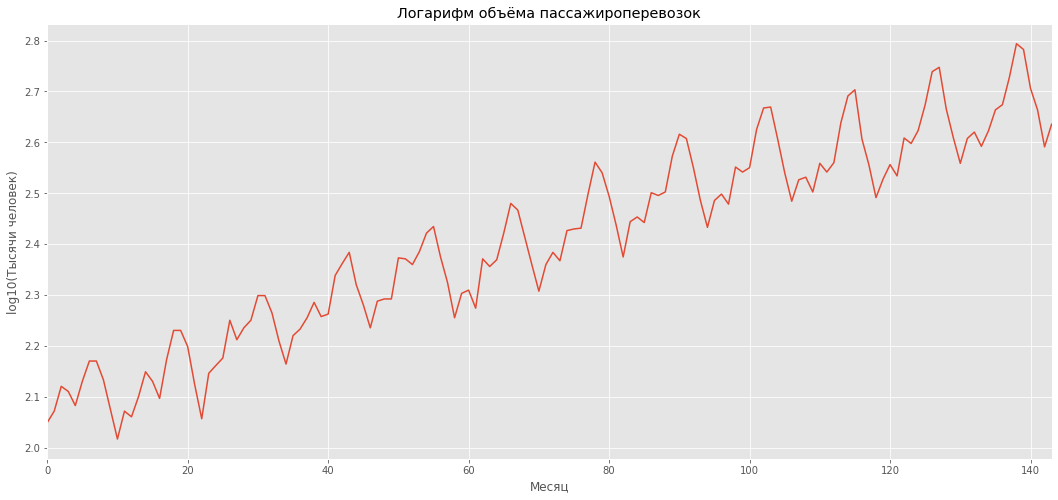

In [38]:
#  Внимание!  Ячейку можно редактировать!
#  А можно не редактировать...
#  Можно изменить размер картинки, подписи осей и заголовок

#  Указываем размер картинки
plt.figure(figsize=(18, 8))

zzz_2.plot()

plt.xlabel(u'Месяц')
plt.ylabel(u'log10(Тысячи человек)')
plt.title(u'Логарифм объёма пассажироперевозок')


plt.show()

In [39]:
#  Заново создаем обучающую часть ряда
#  Вдруг ранее что-то испортили...

zzz_train_2 = zzz_2.iloc[0:train_length]

In [40]:
zzz_train_2

0      2.049218
1      2.071882
2      2.120574
3      2.110590
4      2.082785
         ...   
127    2.747412
128    2.665581
129    2.609594
130    2.558709
131    2.607455
Name: series_g, Length: 132, dtype: float64

In [41]:
#  Заново создаем тестовую часть ряда
#  Вдруг ранее что-то испортили...
#  На этой части временного ряда проверяем качество модели

zzz_test_2 = zzz_2.iloc[train_length:len(zzz_2)]

In [42]:
print(zzz_test_2)

132    2.620136
133    2.592177
134    2.622214
135    2.663701
136    2.673942
137    2.728354
138    2.793790
139    2.782473
140    2.705864
141    2.663701
142    2.591065
143    2.635484
Name: series_g, dtype: float64


In [43]:
#  Какой период сезонных отклонений?
#  Копия, приведена здесь только для напоминания
#  Используется в процедуре в следующей ячейке

#  seas_period_ = 12

#  freq_ = 4
#  freq_ = 7
#  freq_ = 24

In [44]:
model_2 = pm.auto_arima(zzz_train_2, exogenous=None, 
                         start_p=2, d=None, start_q=2, 
                         max_p=2, max_d=2, max_q=2, 
                         start_P=1, D=None, start_Q=1, 
                         max_P=2, max_D=2, max_Q=2, max_order=8, 
                         m = seas_period_,                       #  период сезонн откл
                         seasonal=True, 
                         stationary=False, 
                         information_criterion='aic', 
                         alpha=0.05, 
                         test='kpss', seasonal_test='ch', 
                         stepwise=True, n_jobs=1, start_params=None, 
                         trend='c', method=None, transparams=True, 
                         solver='lbfgs', maxiter=50, 
                         disp=0, callback=None, offset_test_args=None, 
                         seasonal_test_args=None, suppress_warnings=False, 
                         error_action='warn', trace=False, random=False, 
                         random_state=None, n_fits=10, return_valid_fits=False, 
                         out_of_sample_size=0, scoring='mse', scoring_args=None)

C:\Users\USER\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parame

In [45]:
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  132
Model:             SARIMAX(1, 1, 1)x(2, 0, 1, 12)   Log Likelihood                 341.900
Date:                            Mon, 15 Mar 2021   AIC                           -669.800
Time:                                    17:18:13   BIC                           -649.674
Sample:                                         0   HQIC                          -661.622
                                            - 132                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   4.538e-05      0.000      0.272      0.785      -0.000       0.000
ar.L1         -0.2670      0.319     -0.836      0.403      -0.893       0.359
ma.L1         -0.0144      0.344     -0.042      0.967      -0.688       0.660
ar.S.L12       0.9680      0.197      4.915      0.000       0.582       1.354
ar.S.L24       0.0223      0.190      0.117      0.907      -0.350       0.395
ma.S.L12      -0.5554      0.218     -2.551      0.011      -0.982      -0.129
sigma2         0.0002   3.03e-05      8.132      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       39.38   Jarque-Bera (JB):                 0.31
Prob(Q):                              0.50   Prob(JB):                         0.85
Heteroskedasticity (H):               0.42   Skew:                             0.02
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

###  Комментарий для знатоков

Аналитик может лучше <br>
Классическая модель для этого ряда SARIMAX(0, 1, 1)x(0, 1, 1, 12)





In [46]:
model_2.fit(zzz_train_2)

C:\Users\USER\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(1, 1, 1),
      out_of_sample_size=0, scoring='mse', scoring_args={},
      seasonal_order=(2, 0, 1, 12), solver='lbfgs', start_params=None,
      suppress_warnings=False, transparams=True, trend='c',
      with_intercept=True)

In [47]:
#  На сколько месяцев желаем прогнозировать?
#  Копия, приведена здесь только для напоминания
#  horizon_ = 12


In [48]:
#   Значения прогноза для логарифмов 

forecast_2 = model_2.predict(n_periods=horizon_)
forecast_2

array([2.62302675, 2.60222952, 2.66854757, 2.65738382, 2.67458258,
       2.73671535, 2.79120634, 2.79664928, 2.72050629, 2.6651249 ,
       2.6105407 , 2.65568067])

Это прогноз модели ARIMA для тестового множества<br>
Спрогнозированы значения  для тестового множества <br>
Получены для оценки качества прогноза для модели ARIMA

Это не окончательный прогноз

Для получения прогноза по всем историческим данным  <br>
надо вернуться к первому скрипту

In [49]:
#   Значения прогноза для исходного ряда 
10**forecast_2

array([419.7848347 , 400.1561726 , 466.17348605, 454.34297338,
       472.6967122 , 545.40026697, 618.31010251, 626.10803966,
       525.41962577, 462.51401901, 407.88778382, 452.56469756])

In [50]:
#   Номера месяцев, для которых делается прогноз

valid = range(132, 144, 1) 

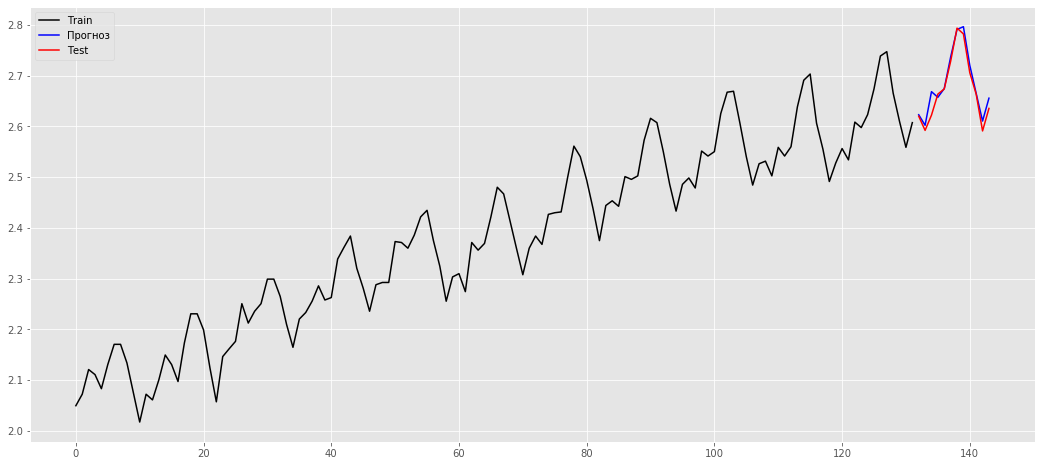

In [51]:
#   Проверяем качество прогноза для логарифмов
#   Строим графики

forecast_3 = pd.DataFrame(forecast_2, index = valid, columns=['Prediction'])

#  Указываем размер картинки
plt.figure(figsize=(18, 8))

#  график ряда логарифмов
plt.plot(zzz_train_2, label='Train', c = 'black')
#  график прогноза для логарифмов
#  plt.plot(forecast_3, label='Forecast', c = 'blue')
plt.plot(forecast_3, label='Прогноз', c = 'blue')

plt.plot(zzz_test_2, label='Test', c = 'red')
plt.legend(loc='best')


plt.show()

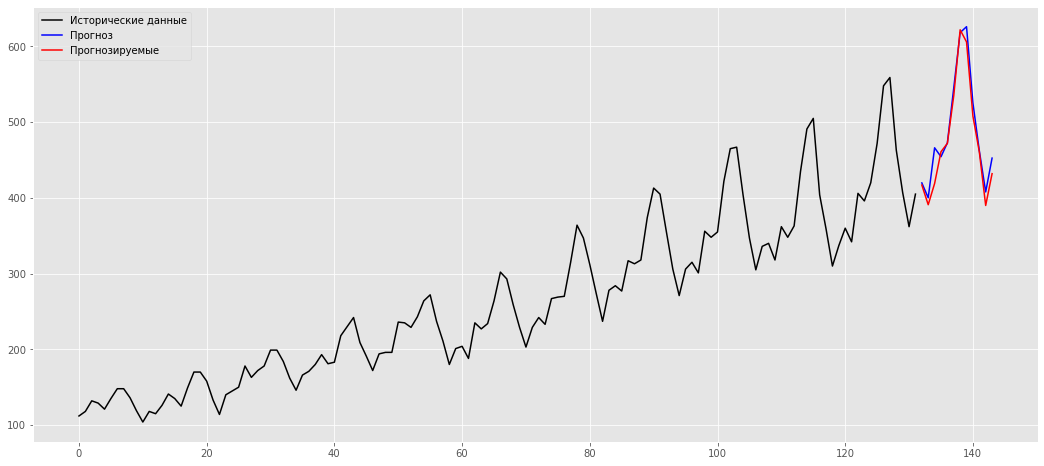

In [52]:
#  По прогнозу для логарифмов вычисляем прогноз для исходного ряда

#   Проверяем качество прогноза для исходного ряда
#   Строим графики

#  Указываем размер картинки
plt.figure(figsize=(18, 8))


#  график исходного ряда
plt.plot(10**zzz_train_2, label='Исторические данные', c = 'black')
#  график прогноза
plt.plot(10**forecast_3, label='Прогноз', c = 'blue')
plt.plot(10**zzz_test_2, label='Прогнозируемые', c = 'red')

plt.legend(loc='best')

plt.show()



In [53]:
forecast_4 = 10**forecast_3.to_numpy().flatten()
zzz_test_3 = 10**zzz_test_2.to_numpy()


In [54]:
#   Mean Absolute Percentage Error
#   Используется неидеальная формула.
#  Если значения временного ряда могутравняться нулю, формулу надо будет менять

MAPE_ARIMA = np.mean(np.abs((forecast_4 - zzz_test_3)/zzz_test_3))*100

print("MAPE для ARIMA = ", MAPE_ARIMA)

MAPE для ARIMA =  2.9016332531452025


###    MAPE для гибридного прогноза

In [75]:
forecast_hybrid = (forecast_.to_numpy() + forecast_4)/2

In [76]:
#   Mean Absolute Percentage Error
#   Используется неидеальная формула.
#  Если значения временного ряда могутравняться нулю, формулу надо будет менять

MAPE_hybrid = np.mean(np.abs((forecast_hybrid - zzz_test_3)/zzz_test_3))*100

print("MAPE для гибридного прогноза = ", MAPE_hybrid)

MAPE для гибридного прогноза =  2.556746777062109
